In [3]:
from merfish3danalysis.qi2labDataStore import qi2labDataStore
from pathlib import Path
import numpy as np
import pandas as pd
from psfmodels import make_psf
from tifffile import imread
from tqdm import tqdm
from merfish3danalysis.utils.dataio import read_metadatafile
from merfish3danalysis.utils.imageprocessing import replace_hot_pixels
from itertools import compress
from typing import Optional

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/pycudadecon/_libwrap.py:44: UserWarning: Unable to find function: camcor_interface_init in libcudaDecon
  @lib.function
/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/pycudadecon/_libwrap.py:51: UserWarning: Unable to find function: camcor_interface in libcudaDecon
  @lib.function


In [8]:
root_path = Path(r"/mnt/d/EQUIPEX/Data/20250603_Test_parsing")
assert root_path.exists()
root_name = root_path.stem
raw_folder = root_path / "Raw"
round1_folder = raw_folder / f"{root_name}_r0001"
assert raw_folder.exists()
list_tile = list(round1_folder.glob("*.ome.tiff"))
list_tile

test_folder = root_path / f"Test folder"
test_folder.mkdir(parents=True, exist_ok=True)

In [9]:
from tifffile import TiffFile
import xmltodict
from dicttoxml import dicttoxml
from xml.dom.minidom import parseString
import json 

sample_path = list_tile[0]
sample_tif = TiffFile(sample_path)

In [7]:
if sample_tif.is_ome : 
    ome_metadata_dict = xmltodict.parse(sample_tif.ome_metadata)['OME']
    description_json = ome_metadata_dict["Folder"][2]['Description'] 
    ome_metadata_dict["Folder"][2]['Description']= json.loads(description_json)
    with open(test_folder / "ome_metadata.json", "w") as f:
        json.dump(ome_metadata_dict,f,indent=4)

In [10]:
sample_path

PosixPath('/mnt/d/EQUIPEX/Data/20250603_Test_parsing/Raw/20250603_Test_parsing_r0001/0250603_Test_parsing_r0001_tile0001.ome.tiff')

In [ ]:
# load raw image
image_path = raw_folder / f"{root_name}_r{(round_idx + 1):04d}" / f"{root_name}_r{(round_idx + 1):04d}_tile{(tile_idx+1):04d}.ome.tiff"

In [ ]:
t = ome_metadata_dict["Folder"][2]['Description']
t

'{"adaptive_optics":{"available":true,"enabled":true,"spherical_3rd_linear":{"intercept":0.5673560550140744,"slope":33373.8855890632}},"current_scan_index":0,"objective_lens":{"name":"60X NA1.3(sil) [UPLSAPO60XS2]"},"region":{"acquisition_offset_x":-0.0013085500797170402,"acquisition_offset_y":0.005806137627190351,"angle_alpha":0,"first_z":-2.3e-05,"first_z_selected":true,"last_z":3.7e-05,"last_z_selected":true,"length_x":0.000106925,"length_y":8.684e-05,"length_z":5.9999999999999995e-05,"microscope_offset_x":0,"microscope_offset_y":0,"offset_z":6.999999999999999e-06,"range_z":5.9999999999999995e-05,"reference_offset_x":-0.0013085500797170402,"reference_offset_y":0.005806137627190351,"scan_length_x":0.000106925,"scan_length_y":8.684e-05,"scan_mode":1,"scan_offset_x":-4.009920282959777e-06,"scan_offset_y":-1.3223728096492526e-06,"stage_offset_x":-0.00131256,"stage_offset_y":0.00580746,"tiles_overlap":5},"sampling":{"lock_square_pixels":false,"step_size_x":6.5e-08,"step_size_y":6.5e-08,"

In [13]:
[channel["@Name"] for channel in ome_metadata_dict["Image"]["Pixels"]["Channel"]]

['ATTO 647N', 'ATTO 565', 'ATTO 488', 'DAPI', 'ATTO 425 Custom']

In [18]:
(int(ome_metadata_dict["Image"]["Pixels"]["@SizeZ"]), int(ome_metadata_dict["Image"]["Pixels"]["@SizeC"]), int(ome_metadata_dict["Image"]["Pixels"]["@SizeY"]),int(ome_metadata_dict["Image"]["Pixels"]["@SizeX"]))

(15, 5, 1183, 1183)

In [8]:
df_experiment_order = pd.read_csv(test_folder / Path("bit_order.csv"))
experiment_order = df_experiment_order.values

In [9]:
df_experiment_order

round  yellow  red
0      1       1    2
1      2       3    4
2      3       5    6
3      4       7    8
4      5       9   10
5      6      11   12
6      7      13   14
7      8      15   16

In [10]:
experiment_order


array([[ 1,  1,  2],
       [ 2,  3,  4],
       [ 3,  5,  6],
       [ 4,  7,  8],
       [ 5,  9, 10],
       [ 6, 11, 12],
       [ 7, 13, 14],
       [ 8, 15, 16]])

In [33]:
df_test = pd.read_csv(test_folder / Path("channel_order.csv"), index_col=0)
df_test.values

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [30]:
dye_order = list(df_test.columns[1:])
dye_order.append('DAPI')
print(dye_order)
channel_order = [channel["@Name"] for channel in ome_metadata_dict["Image"]["Pixels"]["Channel"]]
print(channel_order)
dye_to_chan_dict = {dye_name : channel_order.index(dye_name) for dye_name in dye_order}
print(dye_to_chan_dict)

['ATTO 425 Custom', 'ATTO 488', 'ATTO 565', 'ATTO 647N', 'DAPI']
['ATTO 647N', 'ATTO 565', 'ATTO 488', 'DAPI', 'ATTO 425 Custom']
{'ATTO 425 Custom': 4, 'ATTO 488': 2, 'ATTO 565': 1, 'ATTO 647N': 0, 'DAPI': 3}


In [31]:
dye_order.index('DAPI')

4

In [12]:
dt_test = pd.DataFrame([[False,True, False, False],[False,False, False, False]], columns=["A", "B", "C", "D"])
dt_test

A      B      C      D
0  False   True  False  False
1  False  False  False  False

In [29]:
that = dt_test.any()
that[that].index[0]

'B'

In [34]:
[float(chan["@EmissionWavelength"]) for chan in  ome_metadata_dict["Image"]["Pixels"]["Channel"]]

[6.64e-07, 5.900000000000001e-07, 5.2e-07, 4.61e-07, 4.85e-07]

In [ ]:
ome_metadata_dict["Image"]["Pixels"]["Plane"]

[{'@DeltaT': '0',
  '@DeltaTUnit': 's',
  '@ExposureTime': '6.997444999999999',
  '@ExposureTimeUnit': 's',
  '@PositionX': '0.0020484160993534326',
  '@PositionXUnit': 'm',
  '@PositionY': '0.002843650021747947',
  '@PositionYUnit': 'm',
  '@PositionZ': '-7.815834137377767e-05',
  '@PositionZUnit': 'm',
  '@TheC': '0',
  '@TheT': '0',
  '@TheZ': '0'},
 {'@DeltaT': '0',
  '@DeltaTUnit': 's',
  '@ExposureTime': '6.997444999999999',
  '@ExposureTimeUnit': 's',
  '@PositionX': '0.0020484160993534326',
  '@PositionXUnit': 'm',
  '@PositionY': '0.002843650021747947',
  '@PositionYUnit': 'm',
  '@PositionZ': '-7.785834136316641e-05',
  '@PositionZUnit': 'm',
  '@TheC': '0',
  '@TheT': '0',
  '@TheZ': '1'},
 {'@DeltaT': '0',
  '@DeltaTUnit': 's',
  '@ExposureTime': '6.997444999999999',
  '@ExposureTimeUnit': 's',
  '@PositionX': '0.0020484160993534326',
  '@PositionXUnit': 'm',
  '@PositionY': '0.002843650021747947',
  '@PositionYUnit': 'm',
  '@PositionZ': '-7.755834135255515e-05',
  '@Posit

In [58]:
z_pos = pd.DataFrame(np.array([np.round(float(plane["@PositionZ"])*1e6,2) for plane in ome_metadata_dict["Image"]["Pixels"]["Plane"]]), columns=["Pos"])
z_pos["Axis"] = "Z"
z_pos["Plane"]= [x for x in range(len(ome_metadata_dict["Image"]["Pixels"]["Plane"]))]
y_pos = pd.DataFrame(np.array([np.round(float(plane["@PositionY"])*1e6,2) for plane in ome_metadata_dict["Image"]["Pixels"]["Plane"]]), columns=["Pos"])
y_pos["Axis"] = "Y"
y_pos["Plane"]= [x for x in range(len(ome_metadata_dict["Image"]["Pixels"]["Plane"]))]
x_pos = pd.DataFrame(np.array([np.round(float(plane["@PositionX"])*1e6,2) for plane in ome_metadata_dict["Image"]["Pixels"]["Plane"]]), columns=["Pos"])
x_pos["Axis"] = "X"
x_pos["Plane"]= [x for x in range(len(ome_metadata_dict["Image"]["Pixels"]["Plane"]))]
df_pos = pd.concat([z_pos,y_pos,x_pos])

<Axes: xlabel='Plane', ylabel='Pos'>

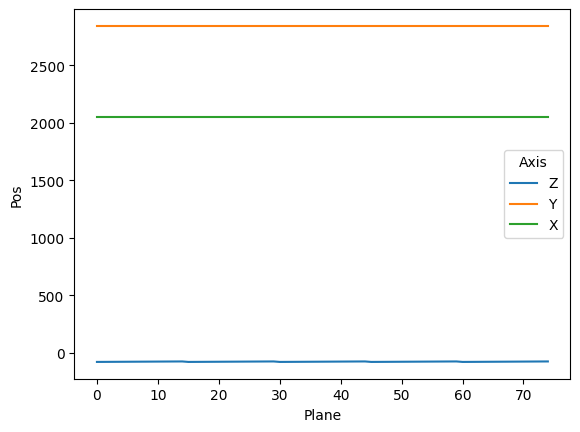

In [59]:
import seaborn as sns 

sns.lineplot(data=df_pos, x="Plane", y="Pos", hue="Axis")

In [60]:
x_pos["Pos"].mean()

2048.4200000000005

In [61]:
x_pos["Pos"][0]

2048.42